<a href="https://colab.research.google.com/github/htapiagroup/sistemas-distribuidos-evaluacion-intersemestral-lomik33/blob/master/SistDist_Examen1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Equipo:
Ismael López Martínez <br/>
Ginna Monzerrat Nava Enríquez<br/>
Francisco García Ortega<br/>
José David Cobos Trujillo<br/>
Examen: https://colab.research.google.com/drive/13lToRPMX3G1jm6Owj195lWWQQ5OLEhiB<br/>
Nota: Los mapas se visualizan abriendo la libreta en colaboratory.

In [0]:
!wget https://archive.org/download/nycTaxiTripData2013/trip_data.7z #descarga del dataset

--2019-06-24 21:41:05--  https://archive.org/download/nycTaxiTripData2013/trip_data.7z
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia902501.us.archive.org/1/items/nycTaxiTripData2013/trip_data.7z [following]
--2019-06-24 21:41:05--  https://ia902501.us.archive.org/1/items/nycTaxiTripData2013/trip_data.7z
Resolving ia902501.us.archive.org (ia902501.us.archive.org)... 207.241.228.211
Connecting to ia902501.us.archive.org (ia902501.us.archive.org)|207.241.228.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4102781969 (3.8G) [application/x-7z-compressed]
Saving to: ‘trip_data.7z’

trip_data.7z        100%[===================>]   3.82G  9.50MB/s    in 8m 46s  

2019-06-24 21:49:51 (7.44 MB/s) - ‘trip_data.7z’ saved [4102781969/4102781969]



In [0]:
!7z l trip_data.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4102781969 bytes (3913 MiB)

Listing archive: trip_data.7z

--
Path = trip_data.7z
Type = 7z
Physical Size = 4102781969
Headers Size = 433
Method = LZMA:24
Solid = -
Blocks = 12

   Date      Time    Attr         Size   Compressed  Name
------------------- ----- ------------ ------------  ------------------------
2014-05-12 22:02:53 ....A   2459600863    345687208  trip_data_1.csv
2014-01-15 06:55:32 ....A   2502278613    358624764  trip_data_10.csv
2014-01-15 07:34:24 ....A   2395449056    342987617  trip_data_11.csv
2014-01-15 08:09:28 ....A   2327237611    331056148  trip_data_12.csv
2014-05-12 22:08:09 ....A   2328673265    327374725  trip_data_2.csv
2013-08-26 02:19:46 ....A   2622301287    371026139  trip_data

In [0]:
import pandas as pd
import numpy as np
import psutil, os 
import dask.dataframe as dd
import gc
import ogr, osr 
import calendar
import math
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN
from datetime import datetime

In [0]:
#Plantilla para descomprimir los archivos del archivo 7z
plantilla = 'trip_data_{:01d}.csv'

In [0]:
#Arreglo contiene el nombre de los archivos que eventualmente se descomprimiran del original
files =[ plantilla.format(month) for month in range(1,13)]

##1 y 2 Procesamiento de archivo trip_data.7z
Nuestro procedimiento consistio en descomprimir archivo por archivo, procesarlo, finalmente borrarlo.<br/>
Con el objetivo de no llenar el espacio en DD, y ahorrar el uso de memoria.

In [0]:
def leer_archivo_puros(fileName):
  plantilla7z='7z x trip_data.7z  -o/content '+ fileName
  #print (plantilla7z)
  os.system(plantilla7z)
  data=dd.read_csv(file,low_memory=False, parse_dates=True, dtype={' store_and_fwd_flag':'object'}).compute() # se carga a dataset    
  os.system('rm '+fileName)  
  return data
  

##3.- Responder las siguientes preguntas:<br/>
A) Cuantas columnas contiene cada archivo de datos descomprimido.<br/>
B) Cuantos renglones tiene cada archivo.

In [0]:
#Con esta función se lee el archivo pero sólo usando las columnas que se usaran en el flujo de datos.
#Se omite la columna store_and_fwd_flag ya que no es relvante para el análisis
#Funcion aportada por Ismael López Martínez
def leer_archivo_depurado(fileName):  
  plantilla7z='7z x trip_data.7z  -o/content '+ fileName
  os.system(plantilla7z)
  data=dd.read_csv(file,low_memory=False, parse_dates=True, usecols=[0,5,6,7,8,9,10,11,12,13], 
                   names=['medallion','pickup_datetime','dropoff_datetime','passenger_count',
                          'trip_time_in_secs','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],header=0, dtype={'trip_distance': 'float64','trip_time_in_secs': 'int64', 'medallion': 'str', 'passenger_count': 'int64','pickup_longitude': 'float64','pickup_latitude':'float64','dropoff_longitude': 'float64', 'dropoff_latitude':'float64'}).compute() # se carga a dataset de pandas    
  os.system('rm '+fileName)  
  return data

In [0]:
dfContar = pd.DataFrame(columns=['Name', 'Columns', 'Rows'])


In [0]:
#Con base a la plantilla de los 12 archivos
#Se procesaron de forma secuencial uno tras otro con la librerias dask
#Para intercalar el uso de los recursos (Memoria, Disco Duro)
#Finalmente el resultado lo dejamos en un DataFrame de Pandas pues no implica gran uso de de los recursos
for file in files:
  df=leer_archivo_puros(file)
  total_rows=len(df.axes[0])
  total_cols=len(df.axes[1])
  new_row=pd.DataFrame({'Name' : file , 'Columns' : total_cols, 'Rows':total_rows},index=[0])  
  dfContar=pd.concat([new_row,dfContar]).reset_index(drop=True)

In [0]:
  dfContar.sort_values(by=['Name'])
  dfContar.head(12)

Name Columns      Rows
0   trip_data_12.csv      14  13971118
1   trip_data_11.csv      14  14388451
2   trip_data_10.csv      14  15004556
3    trip_data_9.csv      14  14107693
4    trip_data_8.csv      14  12597109
5    trip_data_7.csv      14  13823840
6    trip_data_6.csv      14  14385456
7    trip_data_5.csv      14  15285049
8    trip_data_4.csv      14  15100468
9    trip_data_3.csv      14  15749228
10   trip_data_2.csv      14  13990176
11   trip_data_1.csv      14  14776615

###4 Identificar si existen renglones con errores en los datos.<br/>
Por ejemplo si hay columnas de mas (o de menos), si hay campos vacios, etc. Si se detectan renglones con errores:<br/>
A)indicar claramente cuantos son los renglones con errores y a que archivos corresponden <br/>
B)crear un nuevo conjunto de datos con los errores eliminados <br/>

In [0]:
files =[plantilla.format(month) for month in range(1,13)]


In [0]:
#DataFrame con el resumen del proceso de limpieza.
dfLimpiar =  pd.DataFrame(columns=['Name', 'Columns', 'Rows','CantNulos','FueraRangoPasaje','FueraRangoNY','FueraMillas','RowsFinales'])

In [0]:
#Montamos la unidad de google para trabajar con ella y evitar que se llene el espacio de almacenamienta
#Funcion aportada por Horacio Tapía McClung
from google.colab import drive
drive.mount('/content/gdrive' ,force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
quedafiltros=[]

In [0]:
#Proceso de limpieza consistio en cargar la información de los csv sólo las columnas necesarias
#Se eliminan las filas que tengan valores nulos
#Se filtran viajes que tengan arriba de 7 pasajeros
#Se filtran coordenadas que no se encuentren en un cuadrante NYC
#Existe un dato en trip_distance en el mes de agosto que sale de los parametros promedio
#Se filtra todos los viajes donde la distancia sea menor o igual a 100 millas
#Funcion aportada por Francisco García Ortega, José David Cobos
def limpiarDataFrame(df):
    a=len(df.axes[0])
    df=df.dropna()
    quedafiltros.append(a-len(df.axes[0]))
    a=len(df.axes[0])
    df = df[(df['passenger_count'] >0) & (df['passenger_count'] <= 7)]
    quedafiltros.append(a-len(df.axes[0]))
    a=len(df.axes[0])
    df=df[(df['pickup_latitude'] >40.496136) & (df['pickup_latitude'] <40.897877) & (df['pickup_longitude'] >-74.269459)& (df['pickup_longitude'] <-73.690606)]
    quedafiltros.append(a-len(df.axes[0]))
    a=len(df.axes[0])
    df = df[(df['trip_distance'] <=100)]
    quedafiltros.append(a-len(df.axes[0]))
    return df

In [0]:
#Proceso de limpieza de datos se realiza sobre todos los datos del archivo original
#Una vez el dataframe está limpio se almacena en la nube de google en formato gz
  #con el objetivo de tener disponibles los dataset ya limpios para posteriores ejercicios.
for file in files:  
  df=leer_archivo_depurado(file)
  a=limpiarDataFrame(df)
  fname=file
  a.to_csv(fname)  
  gzipCommand="gzip "+fname  
  os.system(gzipCommand)  
  gzipName=fname+".gz"
  os.system( "mv "+gzipName +" \"/content/gdrive/My Drive/Colab Notebooks/"+gzipName+"\"") 
  total_rows=len(df.axes[0])
  total_cols=len(df.axes[1])
  new_row=pd.DataFrame({'Name' : file , 'Columns' : total_cols, 'Rows':total_rows,'CantNulos':quedafiltros[0],'FueraRangoPasaje':quedafiltros[1],'FueraRangoNY':quedafiltros[2],'FueraMillas':quedafiltros[3],'RowsFinales':total_rows-(quedafiltros[0]+quedafiltros[1]+quedafiltros[2]+quedafiltros[3])},index=[0])
  quedafiltros=[]
  dfLimpiar=pd.concat([new_row,dfLimpiar]).reset_index(drop=True)  

In [0]:
dfLimpiar #DataFrame con el resumen del proceso de limpieza.

Name Columns      Rows  ... FueraRangoNY FueraMillas RowsFinales
0   trip_data_12.csv      10  13971118  ...       233359           0    13737388
1   trip_data_11.csv      10  14388451  ...       276720           0    14110841
2   trip_data_10.csv      10  15004556  ...       170721           0    14832995
3    trip_data_9.csv      10  14107693  ...       152414           0    13955107
4    trip_data_8.csv      10  12597109  ...       146214         771    12449759
5    trip_data_7.csv      10  13823840  ...       206778           0    13616255
6    trip_data_6.csv      10  14385456  ...       258610           0    14126351
7    trip_data_5.csv      10  15285049  ...       798965           0    14485959
8    trip_data_4.csv      10  15100468  ...       257812           0    14842425
9    trip_data_3.csv      10  15749228  ...       282785           0    15466014
10   trip_data_2.csv      10  13990176  ...       265047           0    13724921
11   trip_data_1.csv      10  14776615  ...       272796           0    14503650

[12 rows x 8 columns]

###5. Crear un DataFrame usando la libreria pandas y responder lo siguiente:<br/>
A)Indicar el tiempo en segundos, que tarda la libreria pandas en leer un archivo a un  DataFrame<br/>
B)Cual es la huella de memoria del proceso usado para generar el objeto DataFrame <br/>
C)Cuanta memoria del sistema se usa para crear el objeto anterior <br/>
D)Indicar el tiempo que tarda pandas en obtener el promedio de la distancia de viaje (trip_distance) <br/>
*Funcion desarrollada en equipo.


In [0]:
#función tomada de clase Sistemas Distribuidos II Autor: Horacio Tapía
def huella_memoria():
  '''Regresa la huella de memoria usada por un proceso de Python'''
  mem = psutil.Process(os.getpid()).memory_info().rss
  return (mem / 1024**2)

In [0]:
antes = huella_memoria() #A) Indicar el tiempo en segundos, que tarda la libreria pandas en leer un archivo a un DataFrame 
print('Memoria antes: {} MB'.format(antes))
%time df = pd.DataFrame(pd.read_csv('trip_data_1.csv'))
despues = huella_memoria()
print('Memoria despues: {} MB'.format(despues))

Memoria antes: 5106.0625 MB
CPU times: user 47.5 s, sys: 14 s, total: 1min 1s
Wall time: 1min 1s
Memoria despues: 8027.80078125 MB


In [0]:
print('Memoria usada: {} MB'.format(despues-antes)) # B) Cual es la huella de memoria del proceso usado para generar el objeto DataFrame

Memoria usada: 2921.73828125 MB


In [0]:
tam=df.memory_usage().sum() // (1024**2) # C) Cuanta memoria del sistema se usa para crear el objeto anterior
print('Memoria usada por el objeto dataframe: {} MB'.format(tam))

Memoria usada por el objeto dataframe: 1578 MB


In [0]:
%time promedio=df['trip_distance'].mean() # D) Indicar el tiempo que tarda pandas en obtener el promedio de la distancia de viaje (trip_distance)
print('Promedio trip distance {} '.format(promedio))

CPU times: user 28.4 ms, sys: 2.07 ms, total: 30.4 ms
Wall time: 32 ms
Promedio trip distance 2.770975670679966 


###6. Todos los pasos siguientes deben realizarse usando la libreria dask<br/>
A)Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje (trip_distance)<br/>
B)Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (trip_time_in_secs)<br/>
C)Con las columnas pickup_datetime y dropoff_datetime como objetos temporales, crear una nueva columna en los dataframes que se llame duracion y compararla renglon a renglon con la columna trip_time_in_secs<br/>
D)Definir un viaje_largo como aquellos en los que la duracion del viaje (trip_time_in_secs) sea mayor a 20 minutos.<br/>


In [0]:
dfPromedios= pd.DataFrame(columns=['Name', 'Columns', 'Rows','Time_Trip_Distance','Mean_Trip_Distance','Time_Trip_Time_In_Secs','Mean_Trip_Time_In_Secs'])

In [0]:
#Para el procesamiento de los ejercicios se trabajo el proceso de forma individua
#Posteriormente al procesamiento se borra el archivo que se analizó para no llenar el DD.
##Funcion aportada por Ismael López Martínez, Jose David Cobos
def leer_archivo_limpio(fileName, compute=True):
  fileNameExtract=fileName.replace(".gz","")
  plantillaGzip='gzip -dc "/content/gdrive/My Drive/Colab Notebooks/'+ fileName+'" > '+ fileNameExtract  
  os.system(plantillaGzip)
  if compute:
    data=dd.read_csv(fileNameExtract,low_memory=False, parse_dates=True,
                   dtype={'trip_distance': 'float64','trip_time_in_secs': 'int64', 'medallion': 'str', 'passenger_count': 'int64','pickup_longitude': 'float64',
                          'pickup_latitude':'float64','dropoff_longitude': 'float64', 'dropoff_latitude':'float64'}
                    ).compute() # se carga a dataset de dask y se computa
  else:
    data=dd.read_csv(fileNameExtract,low_memory=False, parse_dates=True,
                   dtype={'trip_distance': 'float64','trip_time_in_secs': 'int64', 'medallion': 'str', 'passenger_count': 'int64',
                          'pickup_longitude': 'float64','pickup_latitude':'float64','dropoff_longitude': 'float64', 'dropoff_latitude':'float64'}) 
    # se carga a dataset de dask no se computa
    
  os.system('rm '+fileNameExtract)  
  return data

In [0]:
files =[plantilla.format(month) for month in range(1,13)]

In [0]:
#Proceso de lectura de archivo .gzip con datos limpios para optimizar memoria y disco se descomprimen, se procesa, y se borra el archivo
for file in files:  
  df=leer_archivo_limpio(file)
  t_start = time.time()
  mean_trip_distance=df['trip_distance'].mean()
  t_end = time.time()  
  time_trip_distance=t_end-t_start
  t_start = time.time()
  mean_trip_time_in_secs=df['trip_time_in_secs'].mean()
  t_end = time.time()
  time_trip_time_in_secs=t_end-t_start
  total_rows=len(df.axes[0])  
  total_cols=len(df.axes[1])
  new_row=pd.DataFrame({'Name' : file , 'Columns' : total_cols, 'Rows':total_rows,
                        'Time_Trip_Distance':time_trip_distance,'Mean_Trip_Distance':mean_trip_distance,'Time_Trip_Time_In_Secs':time_trip_time_in_secs,
                        'Mean_Trip_Time_In_Secs':mean_trip_time_in_secs},index=[0])
  dfPromedios=pd.concat([new_row,dfPromedios]).reset_index(drop=True) 
dfPromedios  

Name Columns  ... Time_Trip_Time_In_Secs  Mean_Trip_Time_In_Secs
0   trip_data_12.csv      11  ...               0.025989              789.093469
1   trip_data_11.csv      11  ...               0.026996              775.865342
2   trip_data_10.csv      11  ...               0.027711              785.454424
3    trip_data_9.csv      11  ...               0.025388              785.902557
4    trip_data_8.csv      11  ...               0.023629             1541.909070
5    trip_data_7.csv      11  ...               0.026090              750.594135
6    trip_data_6.csv      11  ...               0.026089              782.405293
7    trip_data_5.csv      11  ...               0.028068              780.132697
8    trip_data_4.csv      11  ...               0.028412              747.699503
9    trip_data_3.csv      11  ...               0.029428              718.598134
10   trip_data_2.csv      11  ...               0.025388              702.955391
11   trip_data_1.csv      11  ...               0.027193              684.448976

[12 rows x 7 columns]

In [0]:
#A)Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje (trip_distance)
#B)Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (trip_time_in_secs)
dfPromedios.mean()

Time_Trip_Distance          0.028929
Mean_Trip_Distance          2.896072
Time_Trip_Time_In_Secs      0.026699
Mean_Trip_Time_In_Secs    820.421583
dtype: float64

In [0]:
#C)Con las columnas pickup_datetime y dropoff_datetime como objetos temporales, crear una nueva columna en los dataframes que se llame duracion y compararla renglon a renglon con la columna trip_time_in_secs
#D)Definir un viaje_largo como aquellos en los que la duracion del viaje (trip_time_in_secs) sea mayor a 20 minutos.
#Funcion aportada por Ginna Nava Enriquez
dfDiferentes = pd.DataFrame(columns=['Archivo','Rows','DatosDiferentes','ViajesLargos'])
dfTop= pd.DataFrame(columns=['Archivo','Medallion','Número_De_Viajes'])
dfTaxisDiferentes = pd.DataFrame (columns=['Archivo','Taxis_Diferentes'])
for file in files:  
  df=leer_archivo_limpio(file)
  df['pickup_datetime'] = dd.to_datetime(df['pickup_datetime'])
  df['dropoff_datetime'] = dd.to_datetime(df['dropoff_datetime'])
  df['duracion']=df['dropoff_datetime']-df['pickup_datetime']
  df['duracion'] = df['duracion'].dt.total_seconds()
  diferentes = df[(df['duracion'] != df['trip_time_in_secs'])]
  viajes_largos=df[(df['duracion']>1200)] #D)
  #8 Funcion aportada por José David Cobos
  medallion = viajes_largos['medallion'].value_counts().keys().tolist()[:1]
  numero = viajes_largos['medallion'].value_counts().tolist()[:1]
  taxisDiferentes = viajes_largos.groupby('medallion')['medallion'].count()
  new_r = pd.DataFrame({'Archivo' : file, 'Medallion' : medallion, 'Número_De_Viajes' : numero})
  r_new = pd.DataFrame({'Archivo' : file, 'Taxis_Diferentes' : len(taxisDiferentes)}, index=[0])
  rows = len(diferentes)
  total_rows=len(df.axes[0])  
  new_row = pd.DataFrame({'Archivo' : file , 'Rows' : total_rows  , 'DatosDiferentes' : rows,'ViajesLargos':len(viajes_largos)},index=[0])
  dfDiferentes = pd.concat([new_row,dfDiferentes]).reset_index (drop=True)
  dfTop = pd.concat([new_r,dfTop]).reset_index (drop=True)
  dfTaxisDiferentes = pd.concat([r_new,dfTaxisDiferentes]).reset_index (drop=True)
 

###7. Contar el numero de viajes largos en cada archivo

In [0]:
#Dataframe con el resumen de "DatosDiferentes" (Contraste de columna "trip_time_in_secs" con "duracion")
dfDiferentes

Archivo      Rows DatosDiferentes ViajesLargos
0   trip_data_12.csv  13737388        13616505      2393939
1   trip_data_11.csv  14110841        13985903      2331471
2   trip_data_10.csv  14832995        14702237      2524007
3    trip_data_9.csv  13955107        13835880      2398956
4    trip_data_8.csv  12450530        12346839      1903575
5    trip_data_7.csv  13616255        13486040      2058195
6    trip_data_6.csv  14126351        14003740      2372239
7    trip_data_5.csv  14485959        14371488      2432819
8    trip_data_4.csv  14842425        14697128      2225154
9    trip_data_3.csv  15466014        15323079      2082677
10   trip_data_2.csv  13724921        13599126      1741161
11   trip_data_1.csv  14503650        14362859      1689386

###8. De los viajes largos. <br/>
A) Identificar el numero de taxis diferentes (la columna medallion contiene un numero que identificada a cada uno de los vehiculos). <br/>
B) Que vehiculos son los que mas viajes realizan en cada mes? Son el mismo vehiculo?

In [0]:
dfTaxisDiferentes #A)

Archivo Taxis_Diferentes
0   trip_data_12.csv            13327
1   trip_data_11.csv            13309
2   trip_data_10.csv            13317
3    trip_data_9.csv            13325
4    trip_data_8.csv            13294
5    trip_data_7.csv            13292
6    trip_data_6.csv            13367
7    trip_data_5.csv            13315
8    trip_data_4.csv            13282
9    trip_data_3.csv            13277
10   trip_data_2.csv            13257
11   trip_data_1.csv            13272

In [0]:
dfTop #B)Los taxis más productivos 
#20BA941F62CC07F1FA3EF3E122B1E9B2 (Septiembre, Octubre, Noviembre)
#A4FC84D2662D988828DBD26B0948A413 (Junio, Julio)


Archivo                         Medallion Número_De_Viajes
0   trip_data_12.csv  5E3D30644F5CAEA4D1C5A07982D6616E              339
1   trip_data_11.csv  20BA941F62CC07F1FA3EF3E122B1E9B2              327
2   trip_data_10.csv  20BA941F62CC07F1FA3EF3E122B1E9B2              366
3    trip_data_9.csv  20BA941F62CC07F1FA3EF3E122B1E9B2              336
4    trip_data_8.csv  5466D714601371299033C01FB08BB93B              288
5    trip_data_7.csv  A4FC84D2662D988828DBD26B0948A413              330
6    trip_data_6.csv  A4FC84D2662D988828DBD26B0948A413              369
7    trip_data_5.csv  20BA941F62CC07F1FA3EF3E122B1E9B2              393
8    trip_data_4.csv  19E063791B0DF5A558B8488180DDAB67              334
9    trip_data_3.csv  DACFA6EF35923081481A22BE96339B6E              308
10   trip_data_2.csv  6FE6DFF9A59C0B64BE0CA64EE2699F08              253
11   trip_data_1.csv  A532B1493C4DD88C450F6796369EAA6F              256

###9.Hacer una grafica temporal del numero total de pasajeros agregados por dias de la semana y despues por horas del dia. <br/>
Sugerencia: agregar por el correspondiente periodo temporal y graficar. <br/>
 ¿Que pueden observar de las graficas?

In [0]:
#Definición de una estructura de agrupación para acumular los datos de los meses
#Funcion aportada por Ismael López Martínez
dft=leer_archivo_limpio('trip_data_1.csv.gz',compute=True)
dft['pickup_datetime'] = dd.to_datetime(dft['pickup_datetime'])
dft['month']=dft['pickup_datetime'].dt.month
dft['weekday'] = dft['pickup_datetime'].dt.weekday
meses_weekday=dft.groupby(['month','weekday'])['passenger_count'].sum()
files =[plantilla.format(month) for month in range(2,13)]
for file in files:  
  df=leer_archivo_limpio(file, compute=True)
  df['pickup_datetime'] = dd.to_datetime(df['pickup_datetime'])
  df['month']=df['pickup_datetime'].dt.month
  df['weekday'] = df['pickup_datetime'].dt.weekday
  meses_weekday=meses_weekday.append(df.groupby(['month','weekday'])['passenger_count'].sum())  

In [0]:
meses_weekday #Objeto Series que permitirá generar la grafica.

month  weekday
1      0          2790921
       1          3831242
       2          3956997
       3          4124987
       4          3513287
       5          3422467
       6          2991408
2      0          2882472
       1          3205113
       2          3345459
       3          3612420
       4          3680287
       5          3402746
       6          3183868
3      0          3017369
       1          3128753
       2          3449740
       3          3609173
       4          4526902
       5          4768835
       6          4021801
4      0          3791254
       1          4046191
       2          3442222
       3          3495529
       4          3721349
       5          3713086
       6          3190988
5      0          3009799
       1          3011234
                   ...   
8      5          3369297
       6          1929767
9      0          3493773
       1          3110410
       2          3218997
       3          3361753
       4          34711

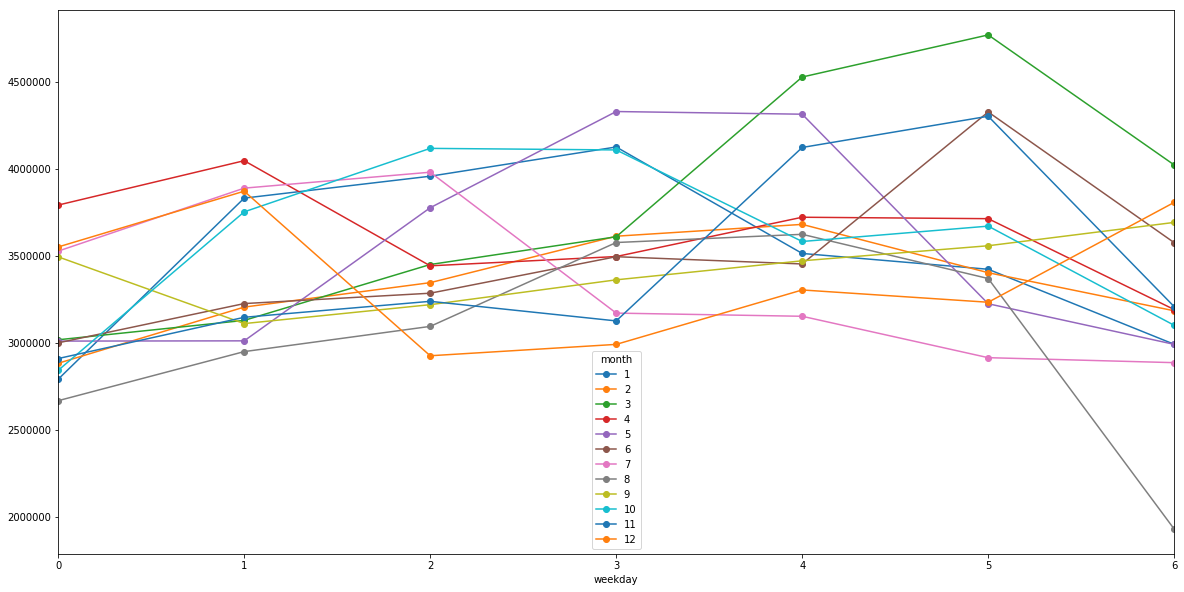

In [0]:
meses_weekday.unstack(level=0).plot(style="-o", figsize=(20,10)) 
#B) Que se observa en las gráficas
#Días más productivos son viernes, sabado por los regular todos los meses.
#El mes de agosto es bajo en casi todos los días excepto jueves y viernes
#El mes de marzo es más productivo para los taxistas los días jueves, viernes y sábado

In [0]:
#Definición de una estructura de agrupación para acumular los datos de los meses (hora y día de la semana)
#Funcion aportada por Ginna Nava Enríquez
dft=leer_archivo_limpio('trip_data_1.csv.gz',compute=True)
dft['pickup_datetime'] = dd.to_datetime(dft['pickup_datetime'])
dft['month']=dft['pickup_datetime'].dt.month
dft['hour'] = dft['pickup_datetime'].dt.hour
meses_hour=dft.groupby(['month','hour'])['passenger_count'].sum()
files =[plantilla.format(month) for month in range(2,13)]
for file in files:  
  df=leer_archivo_limpio(file, compute=True)
  df['pickup_datetime'] = dd.to_datetime(df['pickup_datetime'])
  df['month']=df['pickup_datetime'].dt.month
  df['hour'] = df['pickup_datetime'].dt.hour
  meses_hour=meses_hour.append(df.groupby(['month','hour'])['passenger_count'].sum())

In [0]:
meses_hour #B) Que se observa en las gráficas
#Por lo general el horario de 00:00 a 05:00 hrs va en descenso, a partir de las 05:00 empieza a normalizarce 
#El mes de agosto es bajo en casí todos los horarios.
#El mes de marzo es más productivo para los taxistas.
#Las 17:00 hrs es la hora menos productiva.
#De las 18:00 a 23:00 son las horas donde hay más transporte de psajeros.
##Un punto interesante a destacar es que en EU las jornadas laborales son de 9:00 a 6:00 pm


month  hour
1      0        895100
       1        679078
       2        520733
       3        387305
       4        279507
       5        240178
       6        517432
       7        925386
       8       1155783
       9       1155361
       10      1061759
       11      1080305
       12      1196923
       13      1216841
       14      1296395
       15      1267477
       16      1102752
       17      1290717
       18      1576680
       19      1556779
       20      1408464
       21      1369150
       22      1338258
       23      1112946
2      0        878306
       1        618542
       2        454427
       3        340863
       4        245472
       5        218878
                ...   
11     18      1425820
       19      1520942
       20      1427484
       21      1392603
       22      1347628
       23      1188811
12     0       1015501
       1        756677
       2        557008
       3        402964
       4        294689
       5        237870

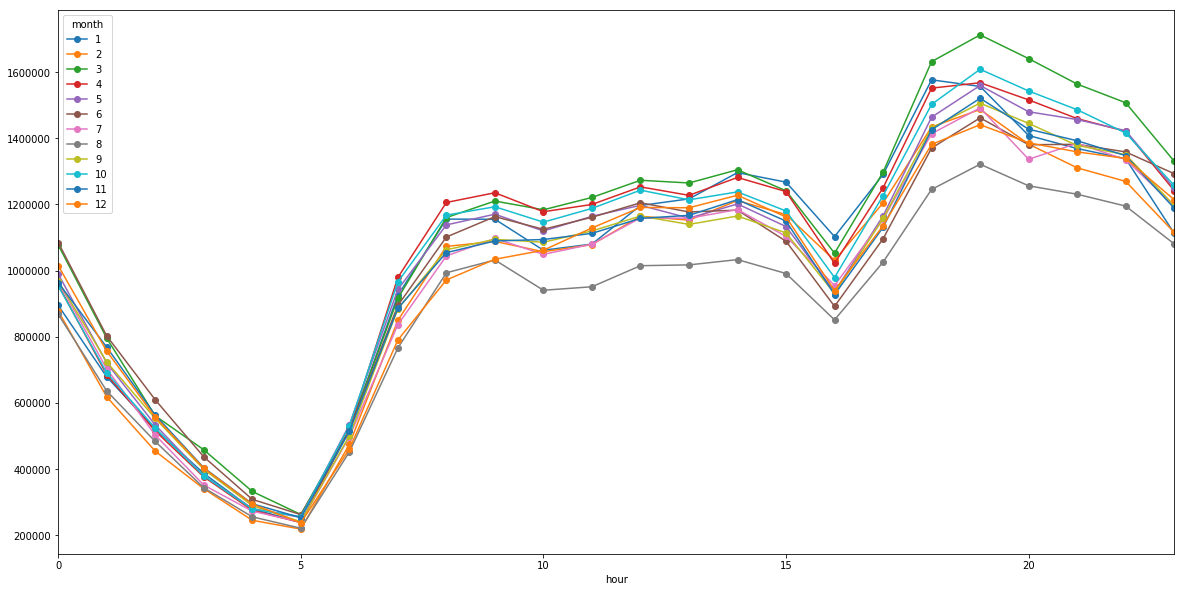

In [0]:
meses_hour.unstack(level=0).plot(style="-o", figsize=(20,10))

##10. Elegir el vehiculo con mas viajes. <br/> 
En cada mes y graficar en un mapa los sitios donde se suben pasajeros agrupados por dia de la semana (un color distinto para cada dia)
hora del dia (un color distinto para cada intervalo de cuatro horas,00:00 - 03:59, 04:00--07:59, 08:00-11:59, etc.)


##11. Repetir para las posiciones donde se bajan los pasajeros para el mismo vehiculo.<br/>


In [0]:

RADIUS = 6378137.0 # metros del ecuador
#Funcion aportada por Ginna Nava Enríquez, Francisco García Ortega cambia a Web Mercator ESRI para poder procesar los mapas. 
def laty(a):
  return np.around(np.log(np.tan(np.pi / 4 + np.radians(a) / 2)) * RADIUS)

def lonx(a):
  return np.around(np.radians(a) * RADIUS)

In [0]:
NYC = x_range, y_range = ((lonx(-74.269459),lonx(-73.690606)), (laty(40.496136),laty(40.897877)))

In [0]:

plot_width  = int(750)
plot_height = int(plot_width//1.2)

In [0]:
#Funcion aportada por Horacio Tapía MClung
def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

In [0]:
def defineColor(color):
  options = dict(line_color=None, fill_color=color, size=5)
  return options


In [0]:
#Funcion aportada por Francisco García Ortega
#Recibe como parámetros el dataframe, el estado si es subida o bajada, la longitud y latitud
#para poder graficar por dia de la semana
def dibujaMapaDias(dfa,estado,long,lat):
  dfa[estado]= pd.to_datetime(dfa[estado]) 
  dfa['weekday']=dfa[estado].dt.weekday #dias de la semana del 0 al 7
  filtroLunes= dfa[dfa['weekday'] ==0]
  filtroMartes= dfa[dfa['weekday'] ==1]
  filtroMiercoles= dfa[dfa['weekday'] ==2]
  filtroJueves= dfa[dfa['weekday'] ==3]
  filtroViernes= dfa[dfa['weekday'] ==4]
  filtroSabado= dfa[dfa['weekday'] ==5]
  filtroDomingo= dfa[dfa['weekday'] ==6]

  output_notebook()
  muestras = dfa
  p = base_plot()
  p.add_tile(STAMEN_TERRAIN)
  p.circle(x=lonx(filtroLunes[long]), y =laty(filtroLunes[lat]), **defineColor('Blue'),legend='Lunes')
  p.circle(x=lonx(filtroMartes[long]), y =laty(filtroMartes[lat]), **defineColor('Red'),legend='Martes')
  p.circle(x=lonx(filtroMiercoles[long]), y =laty(filtroMiercoles[lat]), **defineColor('Green'),legend='Miercoles')
  p.circle(x=lonx(filtroJueves[long]), y =laty(filtroJueves[lat]), **defineColor('Orange'),legend='Jueves')
  p.circle(x=lonx(filtroViernes[long]), y =laty(filtroViernes[lat]), **defineColor('Violet'),legend='Viernes')
  p.circle(x=lonx(filtroSabado[long]), y =laty(filtroSabado[lat]), **defineColor('Yellow'),legend='Sabado')
  p.circle(x=lonx(filtroDomingo[long]), y =laty(filtroDomingo[lat]), **defineColor('Brown'),legend='Domingo')
  show(p)

In [0]:
#Funcion aportada por Francisco García Ortega
#Recibe como parámetros el dataframe, el estado si es subida o bajada, la longitud y latitud
#para poder graficar por rango de horas solicitadas en el ejercicio
def dibujaMapaHoras(dfa,estado,long,lat):
  
 
  dfa[estado]= pd.to_datetime(dfa[estado]) 

  dfa['hour']= dfa[estado].dt.strftime("%H%M")
  
  filtro1= dfa[(dfa['hour'] >='0000')&(dfa['hour']<='0359')]
  filtro2= dfa[(dfa['hour'] >='0400')&(dfa['hour']<='0759')]
  filtro3= dfa[(dfa['hour'] >='0800')&(dfa['hour']<='1159')]
  filtro4= dfa[(dfa['hour'] >='1200')&(dfa['hour']<='1559')]
  filtro5= dfa[(dfa['hour'] >='1600')&(dfa['hour']<='1959')]
  filtro6= dfa[(dfa['hour'] >='2000')&(dfa['hour']<='2359')]
 

  output_notebook()
  muestras = dfa
  p = base_plot()
  p.add_tile(STAMEN_TERRAIN)
  p.circle(x=lonx(filtro1[long]), y =laty(filtro1[lat]), **defineColor('Blue'),legend='00:00-03:59')
  p.circle(x=lonx(filtro2[long]), y =laty(filtro2[lat]), **defineColor('Red'),legend='04:00-07:59')
  p.circle(x=lonx(filtro3[long]), y =laty(filtro3[lat]), **defineColor('Green'),legend='08:00-11:59')
  p.circle(x=lonx(filtro4[long]), y =laty(filtro4[lat]), **defineColor('Orange'),legend='12:00-15:59')
  p.circle(x=lonx(filtro5[long]), y =laty(filtro5[lat]), **defineColor('Violet'),legend='16:00-19:59')
  p.circle(x=lonx(filtro6[long]), y =laty(filtro6[lat]), **defineColor('Yellow'),legend='20:00-23:59')
  show(p)

In [0]:
#Funcion aportada por Francisco García Ortega
#Procedimiento para realizar las 48 graficas
files =[plantilla.format(month) for month in range(1,13)]
for file in files:
    df=leer_archivo_limpio(file)
    a=df
    mejor= a['medallion'].value_counts().keys().tolist()[:1]
    a= a[a['medallion']==mejor[0]]
    print('Graficas medallion: ',mejor[0])
    print('Graficas medallion: ',mejor[0],'pickup')
    print('L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe')
    dibujaMapaDias(a,'pickup_datetime','pickup_longitude','pickup_latitude') #subidas punto 10
    print('Graficas medallion: ',mejor[0],'droppoff')
    print('L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe')
    dibujaMapaDias(a,'dropoff_datetime','dropoff_longitude','dropoff_latitude') #bajadas punto 11
    print('Graficas medallion: ',mejor[0],'pickup')
    print('00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)')
    dibujaMapaHoras(a,'pickup_datetime','pickup_longitude','pickup_latitude')#subidas punto 10
    print('Graficas medallion: ',mejor[0],'dropoff')
    print('00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)')
    dibujaMapaHoras(a,'dropoff_datetime','dropoff_longitude','dropoff_latitude') #bajadas punto 11


Graficas medallion:  7E1346F23960CC18D7D129FA28B63A75
Graficas medallion:  7E1346F23960CC18D7D129FA28B63A75 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  7E1346F23960CC18D7D129FA28B63A75 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  7E1346F23960CC18D7D129FA28B63A75 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  7E1346F23960CC18D7D129FA28B63A75 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  0C9C589C0AD57ECCB633CB90A33DC37A
Graficas medallion:  0C9C589C0AD57ECCB633CB90A33DC37A pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  0C9C589C0AD57ECCB633CB90A33DC37A droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  0C9C589C0AD57ECCB633CB90A33DC37A pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  0C9C589C0AD57ECCB633CB90A33DC37A dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67
Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67
Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2
Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  A4FC84D2662D988828DBD26B0948A413
Graficas medallion:  A4FC84D2662D988828DBD26B0948A413 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  A4FC84D2662D988828DBD26B0948A413 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  A4FC84D2662D988828DBD26B0948A413 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  A4FC84D2662D988828DBD26B0948A413 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  A4FC84D2662D988828DBD26B0948A413
Graficas medallion:  A4FC84D2662D988828DBD26B0948A413 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  A4FC84D2662D988828DBD26B0948A413 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  A4FC84D2662D988828DBD26B0948A413 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  A4FC84D2662D988828DBD26B0948A413 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  5466D714601371299033C01FB08BB93B
Graficas medallion:  5466D714601371299033C01FB08BB93B pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  5466D714601371299033C01FB08BB93B droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  5466D714601371299033C01FB08BB93B pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  5466D714601371299033C01FB08BB93B dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  2905ABD21DF99EA5B9741EA063266632
Graficas medallion:  2905ABD21DF99EA5B9741EA063266632 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  2905ABD21DF99EA5B9741EA063266632 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  2905ABD21DF99EA5B9741EA063266632 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  2905ABD21DF99EA5B9741EA063266632 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2
Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  20BA941F62CC07F1FA3EF3E122B1E9B2 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67
Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  19E063791B0DF5A558B8488180DDAB67 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...

Graficas medallion:  F3E844649503D2A5A44DD729348E7336
Graficas medallion:  F3E844649503D2A5A44DD729348E7336 pickup
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Loading BokehJS ...

Graficas medallion:  F3E844649503D2A5A44DD729348E7336 droppoff
L=Azul, M=Rojo, MM=Verde, J=Naranja, V=Violeta, S=Amarillo, D=Cafe


Loading BokehJS ...

Graficas medallion:  F3E844649503D2A5A44DD729348E7336 pickup
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

Graficas medallion:  F3E844649503D2A5A44DD729348E7336 dropoff
00:00-03:59(Azul),04:00-07:59(Rojo), 08:00-11:59(Verde), 12:00-15:59(Naranja),16:00-19:59(Violeta), 20:00-23:59(Amarillo)


Loading BokehJS ...